In [1]:
%pip install aif360
%pip install 'aif360[Reductions]'
%pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc import \
        OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        opt_tools import OptTools


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
str = '# Start'
display(Markdown(str+' Coding'))

# Start Coding

In [4]:
data_ricci=pd.read_csv('data/Ricci/ricci_processed.csv')
data_ricci

,Position,Oral,Written,Race,Combine,Promotion
0,Captain,89.52,95,W,92.808,Promotion
1,Captain,80.00,95,W,89.000,Promotion
2,Captain,82.38,87,W,85.152,Promotion
3,Captain,88.57,76,W,81.028,Promotion
4,Captain,76.19,84,W,80.876,Promotion
...,...,...,...,...,...,...
113,Lieutenant,40.83,64,H,54.732,No promotion
114,Lieutenant,52.08,56,B,54.432,No promotion
115,Lieutenant,48.33,58,H,54.132,No promotion
116,Lieutenant,52.92,49,B,50.568,No promotion


In [5]:
data_ricci.groupby('Race').describe()

Oral                                                              \
     count       mean        std    min     25%    50%      75%    max   
Race                                                                     
B     27.0  63.952222  10.974650  45.83  55.415  61.25  70.6550  92.08   
H     23.0  57.036957  10.990928  40.83  49.375  56.25  64.8200  79.05   
W     68.0  69.017647  12.039179  44.58  58.645  71.67  77.7075  89.52   

     Written             ...              Combine                       \
       count       mean  ...    75%   max   count       mean       std   
Race                     ...                                             
B       27.0  63.592593  ...  71.50  86.0    27.0  63.736444  8.744066   
H       23.0  70.869565  ...  73.50  84.0    23.0  65.336522  7.142540   
W       68.0  75.117647  ...  82.25  95.0    68.0  72.677647  8.834185   

                                              
         min     25%     50%     75%     max  
Race                                          
B     45.932  57.662  61.068  72.030  76.600  
H     54.132  60.078  65.000  69.946  79.676  
W     56.324  68.015  71.642  78.451  92.808  

[3 rows x 24 columns]

In [6]:
data_ricci.groupby(['Position', 'Race']).describe()['Combine']

count       mean       std     min     25%     50%     75%  \
Position   Race                                                               
Captain    B       8.0  63.782000  8.492689  51.304  57.594  63.900  70.742   
           H       8.0  68.546500  8.701684  57.344  61.685  67.524  76.615   
           W      25.0  74.112800  8.251842  56.324  69.372  73.732  78.124   
Lieutenant B      19.0  63.717263  9.076899  45.932  58.132  61.068  72.482   
           H      15.0  63.624533  5.768875  54.132  60.000  63.268  68.666   
           W      43.0  71.843256  9.145921  56.632  66.434  70.732  78.766   

                    max  
Position   Race          
Captain    B     74.952  
           H     79.676  
           W     92.808  
Lieutenant B     76.600  
           H     71.200  
           W     90.100

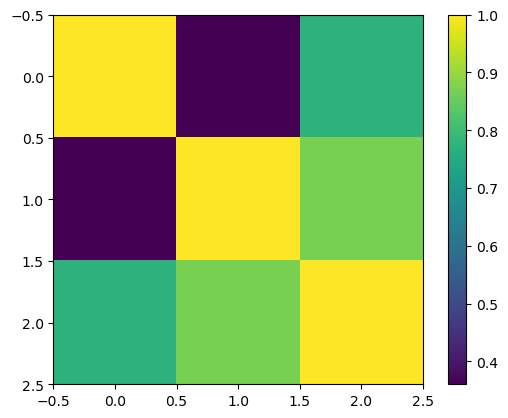

In [7]:
plt.imshow(data_ricci.corr())
plt.colorbar()
plt.show()

## aif360

In [8]:
import aif360
import aif360.metrics
import aif360.datasets

In [9]:
data_ricci=pd.read_csv('data/Ricci/ricci_processed.csv')
data_ricci= data_ricci.replace(['W','B','H','Captain','Lieutenant'],[1,0,0,1,0])
data_ricci= data_ricci.replace(['Promotion','No promotion'],[1,0])

In [10]:
sensitive_attribute = 'Race'
protected_attribute= ['Race']
privileged_group = [{'Race':1}]
unprivileged_group = [{'Race':0}]

In [11]:
dataset= aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = data_ricci, 
                                 label_names= ['Promotion'], 
                                 protected_attribute_names=protected_attribute)

In [12]:
metric = aif360.metrics.BinaryLabelDatasetMetric(dataset, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

In [13]:
dataset_orig=dataset
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
privileged_groups = [{'Race': 1}] # White
unprivileged_groups = [{'Race': 0}] # Not white

In [14]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                  unprivileged_groups=unprivileged_groups,
                  privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % \
        metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.256250


In [18]:
print(metric_orig_train.disparate_impact())

0.5729166666666667


In [27]:
pd.crosstab(data_ricci['Promotion'],data_ricci['Position'],margins=True)

Position,0,1,All
Promotion,,,
0,43,19,62
1,34,22,56
All,77,41,118


We choose the Optimized Pre-Processing algorithm, which is implemented in the OptimPreproc class in the aif360.algorithms.preprocessing directory. This algorithm transforms the dataset to have more equity in positive outcomes on the protected attribute for the privileged and unprivileged groups

In [15]:
optim_options = {
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
    }
OP = OptimPreproc(OptTools, optim_options)
print('oui')
OP = OP.fit(dataset_orig_train)
print('fin')
dataset_transf_train = OP.transform(dataset_orig_train,transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

oui


KeyboardInterrupt: 

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % \
        metric_transf_train.mean_difference())